# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans

1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

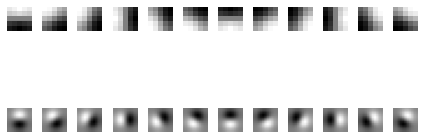

In [2]:
def normalize(image_mat):
    return cv2.normalize(image_mat,dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

def gaussian1D(dim,sigma,derivative_order,x):
    numerator = pow(x,2)
    variance = pow(sigma,2)
    exponent = numerator/variance
    exponent = -0.5*exponent
    comp = np.exp(exponent)
    comp = comp/(sigma*np.sqrt(2*np.pi))
    scale_factor = 1/np.sum(comp)
    comp = comp*scale_factor
    if derivative_order == 1:
        comp = np.multiply(comp,np.asmatrix(x))
        comp = -comp/pow(sigma,2)
    elif derivative_order == 2:
        comp = np.multiply(comp,(numerator - variance)/(pow(variance,2)))
    comp = np.transpose(np.asmatrix(comp))
    return comp

def gaussian2D(dim,sigma_x,sigma_y,x_order,y_order,theta):
    val = math.floor(dim/2)
    x = np.arange(-val,val+1,1)
    y = x
    x2d,y2d = np.meshgrid(x,x)
    coords = np.column_stack((y2d.ravel(),x2d.ravel()))
    rotation_mat = np.matrix([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    points = rotation_mat.dot(coords.transpose())
    ret_x = gaussian1D(dim,sigma_x,x_order,np.asarray(points[0]))
    ret_y = gaussian1D(dim,sigma_y,y_order,np.asarray(points[1]))
    ret = np.multiply(ret_x,ret_y)
    ret = np.reshape(ret,[len(x),len(x)])
    return ret

def OrientedDerivativeOfGaussian(kernel_size,sigma,orient):
    sobel_filter_x = gaussian2D(kernel_size,sigma,sigma,1,0,0)
    sobel_filter_y = gaussian2D(kernel_size,sigma,sigma,0,1,0)
    sobel_filter_x = cv2.filter2D(sobel_filter_x,ddepth=-1,kernel=gaussian2D(3,1,1,0,0,0))
    sobel_filter_y = cv2.filter2D(sobel_filter_y,ddepth=-1,kernel=gaussian2D(3,1,1,0,0,0))
    ret = np.cos(orient)*sobel_filter_x + np.sin(orient)*sobel_filter_y
    return ret

def test_DoG_filterbank():
    scales = [5,10]
    sigma = 2
    orients = np.array([0,30,60,90,120,150,180,210,240,270,300,330])*np.pi/180
    imagesv = []
    fig,axs = plt.subplots(len(scales),len(orients))
    for i,scale in enumerate(scales):
        if len(scales) > 1:
            axi = axs[i]
        else:
            axi = axs
        for j,orient in enumerate(orients):
            if len(orients) > 1:
                axj = axi[j]
            else:
                axj = axj
            val = OrientedDerivativeOfGaussian(scale,sigma,orient)
            axj.imshow(cv2.cvtColor(normalize(val),cv2.COLOR_BGR2RGB))
            axj.axis('off')
            axj.set_xticks([])
            axj.set_yticks([])

    fig.tight_layout()
#     fig.suptitle('Oriented Derivative of Gaussians',fontsize=16,y=0.8)
    plt.savefig('DoG.png',dpi=1200)
test_DoG_filterbank()


1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


<Figure size 2400x2400 with 0 Axes>

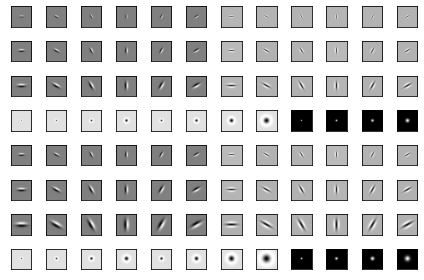

In [3]:
def LM_filterbank(kernel_size,scales):

    orients = np.array([0,30,60,90,120,150])*np.pi/180
    filter_banks = []


    filter_banks = []
    for scale in scales[0:3]:
        scale_filters = []
        #LMS filter_banks first order 6*3 = 18
        for orient in orients:
            scale_filters.append(gaussian2D(kernel_size,scale,3*scale,1,0,orient))
        #LMS filter_banks second order 6*3 = 18
        for orient in orients:
            scale_filters.append(gaussian2D(kernel_size,scale,3*scale,2,0,orient))
        filter_banks.append(scale_filters)

    last_banks = []
    
    #laplacian of gaussians 8
    loG_scales = []
    loG_scales.append(scales)
    loG_scales.append(2*scales)
    loG_scales = [num for elem in loG_scales for num in elem]

    for scale in loG_scales:
        log_x = gaussian2D(kernel_size,scale,scale,2,0,0)
        log_y = gaussian2D(kernel_size,scale,scale,0,2,0)
        last_banks.append(log_x+log_y)
    
    #LMS filter_banks gaussians 4
    for scale in scales:
        last_banks.append(gaussian2D(kernel_size,scale,scale,0,0,0))
    
    filter_banks.append(last_banks)
    return filter_banks

def test_LM_filterbank():
    kernel_size = 49
    scales = np.array([1,np.sqrt(2),2,2*np.sqrt(2)])
    LMS_filter_banks = LM_filterbank(kernel_size,scales)
    plt.figure(figsize=(12,12),dpi=200)
    fig,axs = plt.subplots(np.shape(LMS_filter_banks)[0]*2,np.shape(LMS_filter_banks)[1])
    for i,filters in enumerate(LMS_filter_banks):
        for j,filter_g in enumerate(filters):
            val = normalize(filter_g)
            axs[i,j].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    
    scales = np.array([np.sqrt(2),2,2*np.sqrt(2),4])
    LML_filter_banks = LM_filterbank(kernel_size,scales)
#     fig,axs = plt.subplots(np.shape(LML_filter_banks)[0],np.shape(LMS_filter_banks)[1])
    for i,filters in enumerate(LML_filter_banks):
        for j,filter_g in enumerate(filters):
            val = normalize(filter_g)
            axs[i+np.shape(LMS_filter_banks)[0],j].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
            axs[i+np.shape(LMS_filter_banks)[0],j].set_xticks([])
            axs[i+np.shape(LMS_filter_banks)[0],j].set_yticks([])

#     fig.suptitle('Leung-Malik filters',fontsize=16,y=1.001)
    fig.tight_layout()
    plt.savefig('LM.png',dpi=1200)
test_LM_filterbank()

1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


<Figure size 1600x1600 with 0 Axes>

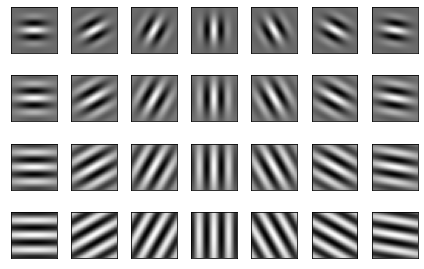

In [4]:
def gabor_filter(dim,lamda,theta,psi,sigma,gamma):
    val = math.floor(dim/2)
    x = np.arange(-val,val+1,1)
    y = x
    x2d,y2d = np.meshgrid(x,x)
    coords = np.column_stack((y2d.ravel(),x2d.ravel()))
    rotation_mat = np.matrix([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
    points = rotation_mat.dot(coords.transpose())
    gaussian_part = np.exp(-(np.power(points[0],2)+np.power(gamma,2)*np.power(points[1],2))/(2*np.power(sigma,2)))
    sinusodial_part_real = np.cos(2*np.pi*points[0]/lamda+psi)
    sinusodial_part_complex = np.sin(2*np.pi*points[0]/lamda+psi)
    comp = []
    comp = np.multiply(gaussian_part,sinusodial_part_real)
    comp = np.reshape(comp,[len(x),len(x)])
    return comp

def create_and_plot_gabor_kernels(plot=False):
    
    gabor_kernel_size = 31

    gabor_sigma = [6,8,12,20]
    gabor_theta = np.pi/180*np.array([0,30,60,90,120,150,170])
    gabor_psi = np.pi/180*np.array([0])
    gabor_lambda = [10]
    gabor_gamma = [1]
    gabor_filters = []
    for sigma in gabor_sigma:
        for theta in gabor_theta:
            for psi in gabor_psi:
                for glambda in gabor_lambda:
                    for gamma in gabor_gamma:
                        g_filter = gabor_filter(gabor_kernel_size,glambda,theta,psi,sigma,gamma)
                        gabor_filters.append(g_filter)

    if plot:
        plt.figure(figsize=(8,8),dpi=200)
        fig, axs = plt.subplots(len(gabor_sigma),len(gabor_theta))
        axs = axs.ravel()
        for i,gfilter in enumerate(gabor_filters):
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            axs[i].imshow(cv2.cvtColor(normalize(gfilter),cv2.COLOR_BGR2RGB))
        fig.tight_layout()
        plt.savefig('Gabor.png')
    return gabor_filters

_ = create_and_plot_gabor_kernels(True)

1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

<Figure size 1600x1600 with 0 Axes>

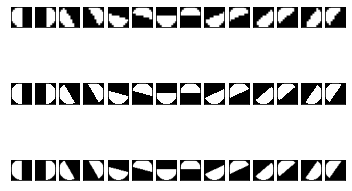

In [5]:
def half_disk_mask_pair(dim,theta):
    val = math.floor(dim/2)
    x = np.arange(-val,val+1,1)
    y = x
    x2d,y2d = np.meshgrid(x,x)
    coords = np.column_stack((y2d.ravel(),x2d.ravel()))
    coords = np.transpose(coords)
    angles = np.arctan2(coords[1],coords[0])
    magnis = np.power(np.power(coords[1],2) + np.power(coords[0],2),0.5)
    image1 = np.full(len(x)*len(x),0)
    image2 = np.full(len(x)*len(x),0)
    
    for i,angle in enumerate(angles):
        if angle >=0 and (angle <= theta or angle == np.pi - theta) and magnis[i] <= len(x)/2:
            image1[i] = 255
        if angle < 0 and angle >= (theta - np.pi) and magnis[i] <= len(x)/2:
            image1[i] = 255
            continue
    for i,angle in enumerate(angles):
        if angle >=0 and (angle > theta and (not angle == np.pi - theta)) and magnis[i] <= len(x)/2:
            image2[i] = 255
        if angle < 0 and (angle < (theta - np.pi)) and magnis[i] <= len(x)/2:
            image2[i] = 255
            continue
    
    image1 = np.reshape(image1,[len(x),len(x)])
    image2 = np.reshape(image2,[len(x),len(x)])
    return [image1,image2]

def plot_half_disk_masks():
    scales = [10,20,30]
    orients = np.array([0,30,75,90,115,130,145])*np.pi/180
    plt.figure(figsize=(8,8),dpi=200)
    fig,axs = plt.subplots(len(scales),2*len(orients))
    for i,scale in enumerate(scales):
        if len(scales) > 1:
            ax = axs[i]
        else:
            ax = axs
        for j,orient in enumerate(orients):
            mask = half_disk_mask_pair(scale,orient)
            mask[0] = normalize(mask[0])
            ax[2*j].set_yticklabels([])
            ax[2*j].set_xticklabels([])
            ax[2*j].set_xticks([])
            ax[2*j].set_yticks([])
            ax[2*j].imshow(cv2.cvtColor(mask[0],cv2.COLOR_BGR2RGB))
            mask[1] = normalize(mask[1])
            ax[2*j+1].set_yticklabels([])
            ax[2*j+1].set_xticklabels([])
            ax[2*j+1].set_xticks([])
            ax[2*j+1].set_yticks([])
            ax[2*j+1].imshow(cv2.cvtColor(mask[1],cv2.COLOR_BGR2RGB))
    plt.savefig('HDMasks.png',dpi=1200)
            
            
plot_half_disk_masks()

1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


In [6]:
def group_filters():
    dog_scaling_factor = 100000
    dog_scales = [5,10]
    dog_sigma = 2
    dog_orients = np.array([0,30,60,90,120,150,180,210,240,270,300,330])*np.pi/180
    dog_filters = []
    for scale in dog_scales:
        for orient in dog_orients:
            dog = OrientedDerivativeOfGaussian(scale,dog_sigma,orient)*10000
            dog_filters.append(dog)
    print("nDoG:",np.shape(dog_filters))

    LM_scaling_factor = 2000
    LM_kernel_size = 49
    LMS_scales = np.array([np.sqrt(2),2,2*np.sqrt(2),4])
    LMS_filters = LM_filterbank(LM_kernel_size,LMS_scales)
    LMS_filters = np.reshape(np.array(LMS_filters),[48,49,49])*LM_scaling_factor
    
    LML_scales = np.array([np.sqrt(2),2,2*np.sqrt(2),4])
    LML_filters = LM_filterbank(LM_kernel_size,LML_scales)
    LML_filters = np.reshape(np.array(LML_filters),[48,49,49])*LM_scaling_factor
    
    LM_filters = LMS_filters.tolist() + LML_filters.tolist()
    print("nLM:",np.shape(LM_filters))
    
    gabor_filters = create_and_plot_gabor_kernels(False)

    print("nGabor:",np.shape(gabor_filters))
    filter_bank = dog_filters
    filter_bank += LM_filters
    filter_bank += gabor_filters
    return filter_bank

def get_cluster_map(img,clusters,n_features):
    img_shape = np.shape(img)
    img_2d = img.reshape(-1,n_features)
    km = KMeans(n_clusters = clusters, init='random',n_init=10,max_iter=300,tol=1e-04, random_state=0)
    clustered_image = km.fit_predict(img_2d)
    clustered_image = np.reshape(clustered_image,(img_shape[0],img_shape[1]))
    return clustered_image

img_color = cv2.imread('./Phase1/BSDS500/Images/4.jpg')
img_grayscale = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
img_shape = np.shape(img_grayscale)


filters = group_filters()
filtered_images = []
for customFilter in filters:
    filtered_images.append(cv2.filter2D(img_grayscale,ddepth=-1,kernel=np.array(customFilter)))



nDoG: (24,)
nLM: (96, 49, 49)
nGabor: (28, 31, 31)


1. Generate texture ID's using K-means clustering
2. Display texton map and save image as TextonMap_ImageName.png,
3. use command "cv2.imwrite('...)"


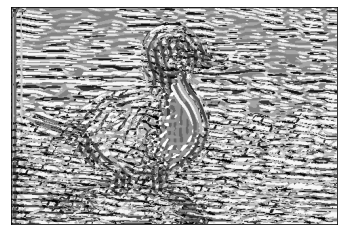

In [7]:
clustered_texture = get_cluster_map(np.transpose(filtered_images,axes=[1,2,0]),64,len(filters))
plt.imshow(cv2.cvtColor(normalize(clustered_texture),cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.savefig('TextonMap_4.png',dpi=1200)

1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


C:\Users\saikr\AppData\Local\Temp\ipykernel_24468\2288219358.py:5: RuntimeWarning: divide by zero encountered in true_divide
  distance = np.divide(distance,(g_i+h_i))


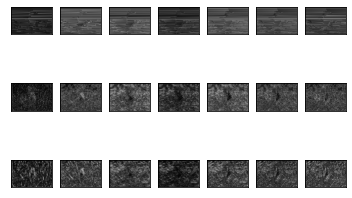

In [8]:
# gradients
def update_chi_sqr_dist(chi_image,g_i,h_i):
    distance = np.power(g_i - h_i,2)
    np.seterr(invalid='ignore')
    distance = np.divide(distance,(g_i+h_i))
    np.seterr(invalid=None)
    distance = distance/2
    chi_image += distance

def interpolate_nan_and_inf(image):
    r_img = image.reshape(-1,1)
    mask = np.logical_or(np.isnan(r_img),np.isinf(r_img))
    r_img[mask] = np.interp(np.flatnonzero(mask),np.flatnonzero(~mask), r_img[~mask])
    image = r_img.reshape(image.shape)
    return image

def get_gradient(img,left_half,right_half):
    chi_image = np.zeros(np.shape(img))
    img0 = img.flatten()
    tmp = np.zeros(np.shape(img0))
    for i in range(255):
        tmp[img0 == i] = 1
        reshaped_tmp = tmp.reshape(img.shape)
        g_i = cv2.filter2D(reshaped_tmp,ddepth=-1,kernel=left_half)
        h_i = cv2.filter2D(reshaped_tmp,ddepth=-1,kernel=right_half)
        update_chi_sqr_dist(chi_image,g_i,h_i)
    chi_image = np.power(chi_image,0.5)
    return chi_image

def get_image_gradients(img):
    scales = [7,11,21]
    orients = np.array([0,30,75,90,115,130,145])*np.pi/180
    images = []
    for scale in scales:
        for orient in orients:
            mask = half_disk_mask_pair(scale,orient)
            gradient_image = get_gradient(img,mask[0],mask[1])
            gradient_image = interpolate_nan_and_inf(gradient_image)
            images.append(gradient_image)
    return images

texture_gradients = get_image_gradients(clustered_texture)
fig,axs = plt.subplots(3,7)
axs = axs.ravel()
for i,tg in enumerate(texture_gradients):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].imshow(cv2.cvtColor(normalize(tg),cv2.COLOR_BGR2RGB))
plt.savefig('Tg_4.png',dpi=1200)


1. Generate Brightness Map
2. Perform brightness binning


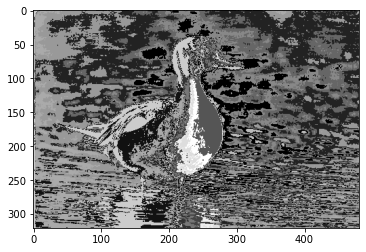

In [9]:
clustered_brightness = get_cluster_map(img_grayscale,16,1)
plt.imshow(cv2.cvtColor(normalize(clustered_brightness),cv2.COLOR_BGR2RGB))

1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



C:\Users\saikr\AppData\Local\Temp\ipykernel_24468\2288219358.py:5: RuntimeWarning: divide by zero encountered in true_divide
  distance = np.divide(distance,(g_i+h_i))


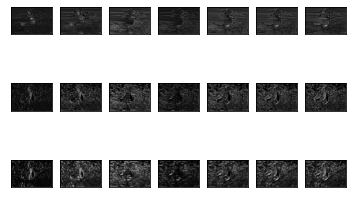

In [14]:
brightness_gradients = get_image_gradients(clustered_brightness)
fig,axs = plt.subplots(3,7)
axs = axs.ravel()
for i,bg in enumerate(brightness_gradients):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].imshow(cv2.cvtColor(normalize(bg),cv2.COLOR_BGR2RGB))
plt.savefig('Bg_4.png',dpi=1200)


1. Generate Color Map
2. Perform color binning or clustering


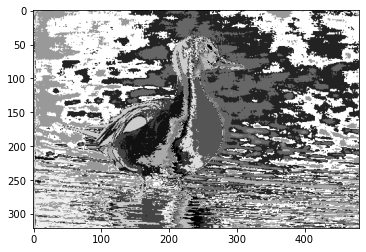

In [15]:
clustered_color = get_cluster_map(img_color,16,3)
plt.imshow(cv2.cvtColor(normalize(clustered_color),cv2.COLOR_BGR2RGB))




1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"



C:\Users\saikr\AppData\Local\Temp\ipykernel_24468\2288219358.py:5: RuntimeWarning: divide by zero encountered in true_divide
  distance = np.divide(distance,(g_i+h_i))


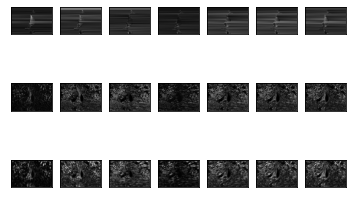

In [16]:
color_gradients = get_image_gradients(clustered_color)
fig,axs = plt.subplots(3,7)
axs = axs.ravel()
for i,cg in enumerate(color_gradients):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].imshow(cv2.cvtColor(normalize(cg),cv2.COLOR_BGR2RGB))
plt.savefig('Cg_4.png',dpi=1200)


1. Read Sobel Baseline
2. use command "cv2.imread(...)"


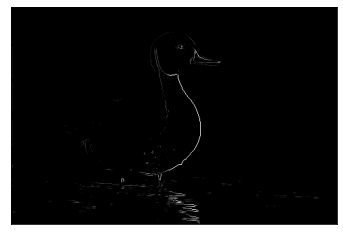

In [17]:
sobel_baseline = cv2.imread('./Phase1/BSDS500/SobelBaseline/4.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(normalize(sobel_baseline),cmap='gist_gray')
_= plt.xticks([]),plt.yticks([])




1. Read Canny Baseline
2. use command "cv2.imread(...)"



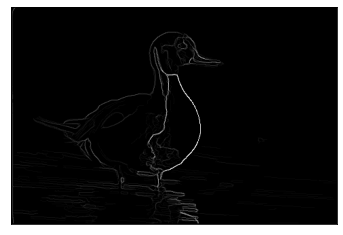

In [18]:
canny_baseline = cv2.imread('./Phase1/BSDS500/CannyBaseline/4.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(normalize(canny_baseline),cmap='gist_gray')
_ = plt.xticks([]),plt.yticks([])



1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



(21, 321, 481)
(21, 321, 481)
(21, 321, 481)


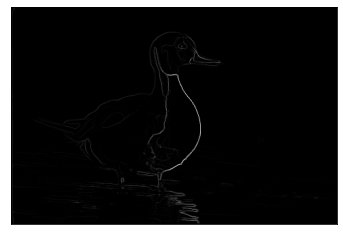

In [19]:
def get_pbEdges(texture_gradients,brightness_gradients,color_gradients,canny_baseline,sobel_baseline,w1,w2):
    sum_of_gradients = np.sum(texture_gradients,axis=0)
    sum_of_gradients += np.sum(brightness_gradients,axis=0)
    sum_of_gradients += np.sum(color_gradients,axis=0)
    gradients_avg = sum_of_gradients/3
    baseline_avg = w1*canny_baseline + w2*sobel_baseline
    #hadamard product
    pbEdges = np.multiply(gradients_avg,baseline_avg)
    return pbEdges
print(np.shape(texture_gradients))
print(np.shape(brightness_gradients))
print(np.shape(color_gradients))

pbEdges = get_pbEdges(texture_gradients,brightness_gradients,color_gradients,canny_baseline,sobel_baseline,0.5,0.5)
plt.imshow(cv2.cvtColor(normalize(pbEdges),cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.savefig('PbLite_4.png',dpi=1200)

## Phase 2

### Neural Network Construction

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out,labels)
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))



class CIFAR10Model(ImageClassificationBase):
    def __init__(self, InputSize, OutputSize):
        super().__init__()
        """
        Inputs: 
        InputSize - Size of the Input
        OutputSize - Size of the Output
        """
        #############################
        # Fill your network initialization of choice here!
        #############################
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # Output size (32 x 32 x 16)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), # Output size (32 x 32 x 32)
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output (16 x 16 x 32)
            nn.Conv2d(32, 64, 3, padding=1), # output(16 x 16 x 64)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), # output (16 x 16 x 128)
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output (8 x 8 x 128)
            nn.Flatten(),
            nn.Linear(8*8*128,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
      
    def forward(self, xb):
        """
        Input:
        xb is a MiniBatch of the current image
        Outputs:
        out - output of the network
        """
        #############################
        # Fill your network structure of choice here!
        #############################
        out = self.network(xb)
        return out


In [31]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime


def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [34]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
#from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Running on device: {device}")

def SetupAll(CheckPointPath):
    """
    Inputs: 
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = './Phase2/Code/TxtFiles/LabelsTrain.txt'
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)
        
    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100 
    
    # Image Input Shape
    ImageSize = [32, 32, 3]
    NumTrainSamples = len(TrainSet)

    # Number of classes
    NumClasses = 10

    return SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
        TrainLabels = open(LabelsPathTrain, 'r')
        TrainLabels = TrainLabels.read()
        TrainLabels = map(float, TrainLabels.split())

    return TrainLabels
    

def ReadDirNames(ReadPath):
    """
    Inputs: 
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames

    
def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize):
    """
    Inputs: 
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch
   
    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels 
    """
    I1Batch = []
    LabelBatch = []
    
    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        RandIdx = random.randint(0, len(TrainSet)-1)
        
        ImageNum += 1
    	
    	  ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        I1, Label = TrainSet[RandIdx]

        # Append All Images and Mask
        I1Batch.append(I1)
        LabelBatch.append(torch.tensor(Label))
        
    return torch.stack(I1Batch).to(device), torch.stack(LabelBatch).to(device)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)              

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs: 
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10)
    model = model.to(device)
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')
    
    model.train()
    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize)
            
            # Predict output with forward pass
            LossThisBatch = model.training_step(Batch)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()
            
            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:
                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'
                
                torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                print('\n' + SaveName + ' Model Saved...')

            result = model.validation_step(Batch)
            model.epoch_end(Epochs*NumIterationsPerEpoch + PerEpochCounter, result)
            # Tensorboard
            Writer.add_scalar('LossEveryIter', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            Writer.add_scalar('Accuracy', result["acc"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            # If you don't flush the tensorboard doesn't update until a lot of iterations!
            Writer.flush()

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')
        


# Default Hyperparameters
NumEpochs = 20
TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 16
LoadCheckPoint = 0
CheckPointPath = "./content2/Checkpoints/"
LogsPath = "./content2/Logs/"

# Setup all needed parameters including file reading
SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

Running on device: cuda
Files already downloaded and verified
Number of Epochs Training will run for 20
Factor of reduction in training data is 1.0
Mini Batch Size 16
Number of Training Images 50000
New model initialized....


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

<class 'torch.Tensor'>

./content2/Checkpoints/0a0model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [0], loss: 2.3008, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1], loss: 2.2802, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2], loss: 2.3100, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3], loss: 2.3313, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4], loss: 2.3079, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5], loss: 2.3026, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6], loss: 2.3077, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7], loss: 2.3097, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [8], loss: 2.2999, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [9], loss: 2.2921, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [10], loss: 2.3132, acc: 0.0000
<class 'torch.Tensor'>
<class 'to

<class 'torch.Tensor'>
Epoch [98], loss: 2.2992, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [99], loss: 2.3059, acc: 0.0625
<class 'torch.Tensor'>

./content2/Checkpoints/0a100model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [100], loss: 2.3179, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [101], loss: 2.2856, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [102], loss: 2.3173, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [103], loss: 2.3146, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [104], loss: 2.3239, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [105], loss: 2.2996, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [106], loss: 2.2995, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [107], loss: 2.3052, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [108], loss: 2.3001, acc: 0.0625
<class 'torch.Tensor'>
<class 'torc


./content2/Checkpoints/0a200model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [200], loss: 2.2971, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [201], loss: 2.2895, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [202], loss: 2.3049, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [203], loss: 2.3210, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [204], loss: 2.3126, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [205], loss: 2.3064, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [206], loss: 2.2928, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [207], loss: 2.2969, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [208], loss: 2.3047, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [209], loss: 2.2802, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [210], loss: 2.3117, acc: 0.0000
<class 'torch.Tensor'>
<class 'to

<class 'torch.Tensor'>
Epoch [305], loss: 2.3003, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [306], loss: 2.2893, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [307], loss: 2.3069, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [308], loss: 2.3175, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [309], loss: 2.2954, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [310], loss: 2.2988, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [311], loss: 2.2922, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [312], loss: 2.3016, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [313], loss: 2.2894, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [314], loss: 2.2990, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [315], loss: 2.2968, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [316], loss: 2.3012, acc: 0.0625
<cl

<class 'torch.Tensor'>
Epoch [402], loss: 2.3095, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [403], loss: 2.2836, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [404], loss: 2.2995, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [405], loss: 2.3073, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [406], loss: 2.2940, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [407], loss: 2.3010, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [408], loss: 2.2872, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [409], loss: 2.3040, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [410], loss: 2.2935, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [411], loss: 2.3091, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [412], loss: 2.2951, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [413], loss: 2.3058, acc: 0.0625
<cl

Epoch [500], loss: 2.3305, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [501], loss: 2.3171, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [502], loss: 2.3137, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [503], loss: 2.3133, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [504], loss: 2.2920, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [505], loss: 2.3081, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [506], loss: 2.3183, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [507], loss: 2.2914, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [508], loss: 2.2969, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [509], loss: 2.2952, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [510], loss: 2.3092, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [511], loss: 2.3089, acc: 0.0625
<class 'torch.Tensor'>
<cl

<class 'torch.Tensor'>
Epoch [597], loss: 2.2954, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [598], loss: 2.2995, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [599], loss: 2.3016, acc: 0.0000
<class 'torch.Tensor'>

./content2/Checkpoints/0a600model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [600], loss: 2.2998, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [601], loss: 2.2935, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [602], loss: 2.2958, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [603], loss: 2.2949, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [604], loss: 2.2927, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [605], loss: 2.3019, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [606], loss: 2.3020, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [607], loss: 2.3009, acc: 0.0625
<class 'torch.Tensor'>
<class 'to

Epoch [700], loss: 2.3027, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [701], loss: 2.3077, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [702], loss: 2.2986, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [703], loss: 2.3150, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [704], loss: 2.3106, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [705], loss: 2.3022, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [706], loss: 2.2920, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [707], loss: 2.2979, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [708], loss: 2.3022, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [709], loss: 2.3062, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [710], loss: 2.3060, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [711], loss: 2.3034, acc: 0.0625
<class 'torch.Tensor'>
<cl

<class 'torch.Tensor'>
Epoch [798], loss: 2.3081, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [799], loss: 2.2937, acc: 0.0625
<class 'torch.Tensor'>

./content2/Checkpoints/0a800model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [800], loss: 2.3063, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [801], loss: 2.2921, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [802], loss: 2.3040, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [803], loss: 2.2977, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [804], loss: 2.3013, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [805], loss: 2.3037, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [806], loss: 2.3064, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [807], loss: 2.3032, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [808], loss: 2.2923, acc: 0.3125
<class 'torch.Tensor'>
<class 'to

<class 'torch.Tensor'>
Epoch [898], loss: 2.3023, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [899], loss: 2.3073, acc: 0.1250
<class 'torch.Tensor'>

./content2/Checkpoints/0a900model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [900], loss: 2.3072, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [901], loss: 2.3050, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [902], loss: 2.2917, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [903], loss: 2.2877, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [904], loss: 2.3012, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [905], loss: 2.2994, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [906], loss: 2.3060, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [907], loss: 2.3165, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [908], loss: 2.2885, acc: 0.1875
<class 'torch.Tensor'>
<class 'to

Epoch [997], loss: 2.3015, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [998], loss: 2.3112, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [999], loss: 2.3052, acc: 0.0625
<class 'torch.Tensor'>

./content2/Checkpoints/0a1000model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [1000], loss: 2.3053, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1001], loss: 2.3026, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1002], loss: 2.3034, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1003], loss: 2.3057, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1004], loss: 2.2970, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1005], loss: 2.3116, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1006], loss: 2.3054, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1007], loss: 2.2977, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
E

Epoch [1100], loss: 2.2987, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1101], loss: 2.2887, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1102], loss: 2.3072, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1103], loss: 2.2978, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1104], loss: 2.2924, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1105], loss: 2.3059, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1106], loss: 2.3048, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1107], loss: 2.2798, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1108], loss: 2.2815, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1109], loss: 2.2810, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1110], loss: 2.3168, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1111], loss: 2.2837, acc: 0.1875
<class 'torch.

<class 'torch.Tensor'>
Epoch [1205], loss: 2.2933, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1206], loss: 2.3135, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1207], loss: 2.2888, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1208], loss: 2.3076, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1209], loss: 2.2849, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1210], loss: 2.2736, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1211], loss: 2.3250, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1212], loss: 2.2812, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1213], loss: 2.2927, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1214], loss: 2.2820, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1215], loss: 2.2830, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1216], loss: 2.3016, acc

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1302], loss: 2.2889, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1303], loss: 2.3029, acc: 0.0000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1304], loss: 2.2914, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1305], loss: 2.2912, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1306], loss: 2.2942, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1307], loss: 2.3046, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1308], loss: 2.2900, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1309], loss: 2.3027, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1310], loss: 2.3097, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1311], loss: 2.2872, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1312], loss: 2.2904, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1403], loss: 2.2900, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1404], loss: 2.2864, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1405], loss: 2.3027, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1406], loss: 2.2868, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1407], loss: 2.2937, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1408], loss: 2.2924, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1409], loss: 2.2666, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1410], loss: 2.3180, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1411], loss: 2.2693, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1412], loss: 2.2823, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1413], loss: 2.2956, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1

<class 'torch.Tensor'>
Epoch [1498], loss: 2.2574, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1499], loss: 2.2447, acc: 0.1875
<class 'torch.Tensor'>

./content2/Checkpoints/0a1500model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [1500], loss: 2.3067, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1501], loss: 2.2496, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1502], loss: 2.2911, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1503], loss: 2.2870, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1504], loss: 2.2873, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1505], loss: 2.3135, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1506], loss: 2.2792, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1507], loss: 2.2684, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1508], loss: 2.3098, acc: 0.0625
<class 'torch.Tensor'

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1603], loss: 2.2831, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1604], loss: 2.1978, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1605], loss: 2.2622, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1606], loss: 2.2089, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1607], loss: 2.2662, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1608], loss: 2.2176, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1609], loss: 2.2245, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1610], loss: 2.2470, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1611], loss: 2.2288, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1612], loss: 2.2167, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1613], loss: 2.2761, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1


./content2/Checkpoints/0a1700model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [1700], loss: 2.1026, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1701], loss: 2.0802, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1702], loss: 2.2553, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1703], loss: 2.2405, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1704], loss: 2.1977, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1705], loss: 2.2298, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1706], loss: 2.1618, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1707], loss: 2.1278, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1708], loss: 2.2236, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1709], loss: 2.1880, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1710], loss: 2.2919, acc: 0.1875
<class 'torch.Tensor'

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1802], loss: 2.2340, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1803], loss: 2.2590, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1804], loss: 2.1895, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1805], loss: 2.1678, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1806], loss: 2.1130, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1807], loss: 2.0948, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1808], loss: 2.1818, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1809], loss: 2.2104, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1810], loss: 2.0807, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1811], loss: 2.2012, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1812], loss: 2.1475, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1907], loss: 2.2512, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1908], loss: 2.0839, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1909], loss: 1.9356, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1910], loss: 2.2008, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1911], loss: 2.1251, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1912], loss: 2.0162, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1913], loss: 2.1529, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1914], loss: 2.2197, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1915], loss: 2.1259, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1916], loss: 2.1076, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1917], loss: 2.3905, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [1

<class 'torch.Tensor'>
Epoch [2004], loss: 2.0985, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2005], loss: 2.3094, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2006], loss: 1.9313, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2007], loss: 2.0055, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2008], loss: 2.0319, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2009], loss: 2.1137, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2010], loss: 2.0106, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2011], loss: 2.0432, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2012], loss: 1.9670, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2013], loss: 2.1355, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2014], loss: 2.0721, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2015], loss: 2.1781, acc

Epoch [2100], loss: 2.0575, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2101], loss: 1.8840, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2102], loss: 2.2070, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2103], loss: 2.1017, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2104], loss: 2.0176, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2105], loss: 2.0507, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2106], loss: 2.0505, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2107], loss: 2.2064, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2108], loss: 1.9321, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2109], loss: 1.9678, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2110], loss: 1.8519, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2111], loss: 2.0997, acc: 0.2500
<class 'torch.

Epoch [2196], loss: 1.9830, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2197], loss: 2.1037, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2198], loss: 2.1735, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2199], loss: 1.9043, acc: 0.2500
<class 'torch.Tensor'>

./content2/Checkpoints/0a2200model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [2200], loss: 2.1400, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2201], loss: 2.0855, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2202], loss: 1.8699, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2203], loss: 2.2061, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2204], loss: 2.1759, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2205], loss: 2.1151, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2206], loss: 2.3635, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'

Epoch [2300], loss: 1.6973, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2301], loss: 2.1008, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2302], loss: 1.7279, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2303], loss: 2.1827, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2304], loss: 2.0073, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2305], loss: 2.2940, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2306], loss: 2.1335, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2307], loss: 1.9136, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2308], loss: 2.0052, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2309], loss: 1.9533, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2310], loss: 2.0792, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2311], loss: 2.0066, acc: 0.4375
<class 'torch.

<class 'torch.Tensor'>
Epoch [2397], loss: 2.3573, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2398], loss: 1.8066, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2399], loss: 1.9830, acc: 0.3125
<class 'torch.Tensor'>

./content2/Checkpoints/0a2400model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [2400], loss: 2.0761, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2401], loss: 2.1476, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2402], loss: 2.1098, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2403], loss: 2.0844, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2404], loss: 2.0975, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2405], loss: 2.0362, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2406], loss: 2.2201, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2407], loss: 2.2317, acc: 0.1875
<class 'torch.Tensor'

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2493], loss: 1.7960, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2494], loss: 1.8477, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2495], loss: 1.8990, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2496], loss: 1.8199, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2497], loss: 2.0167, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2498], loss: 2.0803, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2499], loss: 1.8450, acc: 0.3125
<class 'torch.Tensor'>

./content2/Checkpoints/0a2500model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [2500], loss: 2.0635, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2501], loss: 1.9071, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2502], loss: 2.0273, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2503], loss: 1.9177, acc: 0.187

<class 'torch.Tensor'>
Epoch [2589], loss: 1.7627, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2590], loss: 1.6843, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2591], loss: 1.6731, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2592], loss: 1.7668, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2593], loss: 1.9801, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2594], loss: 2.1885, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2595], loss: 1.9387, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2596], loss: 1.7664, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2597], loss: 1.9958, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2598], loss: 1.9311, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2599], loss: 1.8680, acc: 0.1875
<class 'torch.Tensor'>

./content2/Checkpoints/0a2600model.ckpt Model Saved..

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2688], loss: 1.8667, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2689], loss: 1.9027, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2690], loss: 2.1116, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2691], loss: 1.9026, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2692], loss: 1.8291, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2693], loss: 2.1888, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2694], loss: 1.5506, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2695], loss: 1.7029, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2696], loss: 1.9087, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2697], loss: 2.0307, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2698], loss: 1.8810, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2

<class 'torch.Tensor'>
Epoch [2787], loss: 2.1274, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2788], loss: 1.8251, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2789], loss: 2.0257, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2790], loss: 1.5796, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2791], loss: 1.9290, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2792], loss: 1.8530, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2793], loss: 1.7192, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2794], loss: 2.3283, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2795], loss: 2.3589, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2796], loss: 1.9020, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2797], loss: 2.0414, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2798], loss: 2.0367, acc

<class 'torch.Tensor'>
Epoch [2892], loss: 1.8984, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2893], loss: 1.6919, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2894], loss: 1.5453, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2895], loss: 1.8712, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2896], loss: 2.0895, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2897], loss: 1.9212, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2898], loss: 2.1851, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2899], loss: 1.7490, acc: 0.5000
<class 'torch.Tensor'>

./content2/Checkpoints/0a2900model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [2900], loss: 2.2667, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2901], loss: 2.2546, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2902], loss: 2.0754, acc: 0.3125
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [2987], loss: 1.9865, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2988], loss: 1.9537, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2989], loss: 1.8852, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2990], loss: 1.9416, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2991], loss: 1.6710, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2992], loss: 2.1491, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2993], loss: 1.8705, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2994], loss: 1.8150, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2995], loss: 2.0190, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2996], loss: 1.5474, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2997], loss: 2.1910, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [2998], loss: 1.9942, acc

<class 'torch.Tensor'>
Epoch [3089], loss: 1.8834, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3090], loss: 1.8586, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3091], loss: 1.9235, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3092], loss: 1.9662, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3093], loss: 1.4888, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3094], loss: 1.8114, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3095], loss: 2.0996, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3096], loss: 2.3147, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3097], loss: 2.1362, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3098], loss: 2.0527, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3099], loss: 1.9886, acc: 0.3125
<class 'torch.Tensor'>

./content2/Checkpoints/0a3100model.ckpt Model Saved..

  0%|          | 0/3125 [00:00<?, ?it/s]

<class 'torch.Tensor'>

./content2/Checkpoints/1a0model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [3125], loss: 1.8352, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3126], loss: 1.8784, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3127], loss: 1.8759, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3128], loss: 2.0408, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3129], loss: 1.8041, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3130], loss: 2.0969, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3131], loss: 1.9137, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3132], loss: 1.8955, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3133], loss: 1.8097, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3134], loss: 2.1535, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3135], loss: 2.0604, acc: 0.0625
<


./content2/Checkpoints/1a100model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [3225], loss: 1.7375, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3226], loss: 1.8487, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3227], loss: 1.9876, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3228], loss: 1.9368, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3229], loss: 1.5797, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3230], loss: 1.8907, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3231], loss: 1.5338, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3232], loss: 1.7749, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3233], loss: 1.7878, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3234], loss: 1.6948, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3235], loss: 1.8204, acc: 0.3125
<class 'torch.Tensor'>


./content2/Checkpoints/1a200model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [3325], loss: 2.0013, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3326], loss: 1.8458, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3327], loss: 2.0027, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3328], loss: 1.8353, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3329], loss: 1.7736, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3330], loss: 1.6988, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3331], loss: 1.6785, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3332], loss: 2.0633, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3333], loss: 2.1089, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3334], loss: 1.7295, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3335], loss: 2.1096, acc: 0.3125
<class 'torch.Tensor'>

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3424], loss: 1.7141, acc: 0.3750
<class 'torch.Tensor'>

./content2/Checkpoints/1a300model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [3425], loss: 2.0572, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3426], loss: 1.8091, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3427], loss: 2.1409, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3428], loss: 1.8703, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3429], loss: 1.9836, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3430], loss: 1.9505, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3431], loss: 1.7834, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3432], loss: 1.6797, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3433], loss: 1.5529, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3434], loss: 1.6736, acc: 0.4375

Epoch [3524], loss: 2.4452, acc: 0.0000
<class 'torch.Tensor'>

./content2/Checkpoints/1a400model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [3525], loss: 1.8902, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3526], loss: 2.0129, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3527], loss: 1.8867, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3528], loss: 1.8070, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3529], loss: 1.8513, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3530], loss: 1.8655, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3531], loss: 1.9801, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3532], loss: 1.7754, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3533], loss: 1.8694, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3534], loss: 2.0702, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3627], loss: 2.0758, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3628], loss: 2.1704, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3629], loss: 1.7815, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3630], loss: 1.7959, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3631], loss: 1.7224, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3632], loss: 2.4585, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3633], loss: 1.9542, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3634], loss: 1.9519, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3635], loss: 1.8208, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3636], loss: 1.7585, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3637], loss: 1.6632, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3724], loss: 1.9055, acc: 0.3125
<class 'torch.Tensor'>

./content2/Checkpoints/1a600model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [3725], loss: 1.7016, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3726], loss: 2.0047, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3727], loss: 2.0455, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3728], loss: 1.4143, acc: 0.7500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3729], loss: 1.6200, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3730], loss: 2.0466, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3731], loss: 1.7975, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3732], loss: 1.7452, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3733], loss: 1.7802, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3734], loss: 1.6608, acc: 0.3125

Epoch [3825], loss: 1.6915, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3826], loss: 1.3509, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3827], loss: 1.8747, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3828], loss: 1.8081, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3829], loss: 1.7575, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3830], loss: 1.7439, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3831], loss: 1.8865, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3832], loss: 2.0121, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3833], loss: 2.0411, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3834], loss: 1.4140, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3835], loss: 1.5373, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3836], loss: 1.4933, acc: 0.5000
<class 'torch.


./content2/Checkpoints/1a800model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [3925], loss: 1.8328, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3926], loss: 1.6632, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3927], loss: 1.6316, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3928], loss: 1.7861, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3929], loss: 1.2378, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3930], loss: 1.7405, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3931], loss: 1.6076, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3932], loss: 1.6184, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3933], loss: 1.4588, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3934], loss: 1.7413, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [3935], loss: 2.1345, acc: 0.3125
<class 'torch.Tensor'>

Epoch [4029], loss: 1.8581, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4030], loss: 1.4972, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4031], loss: 1.6966, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4032], loss: 1.9152, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4033], loss: 1.6814, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4034], loss: 1.6961, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4035], loss: 1.5092, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4036], loss: 1.6382, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4037], loss: 1.8606, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4038], loss: 1.5437, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4039], loss: 1.3249, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4040], loss: 1.4453, acc: 0.4375
<class 'torch.


./content2/Checkpoints/1a1000model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4125], loss: 1.6276, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4126], loss: 1.7842, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4127], loss: 1.9467, acc: 0.0625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4128], loss: 1.7107, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4129], loss: 1.6774, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4130], loss: 2.0758, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4131], loss: 1.7238, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4132], loss: 1.5985, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4133], loss: 2.0527, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4134], loss: 1.4739, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4135], loss: 1.5239, acc: 0.5000
<class 'torch.Tensor'

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4221], loss: 2.3811, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4222], loss: 1.5567, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4223], loss: 1.6338, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4224], loss: 1.6572, acc: 0.3750
<class 'torch.Tensor'>

./content2/Checkpoints/1a1100model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4225], loss: 1.6503, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4226], loss: 1.6614, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4227], loss: 1.7473, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4228], loss: 1.6385, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4229], loss: 1.4748, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4230], loss: 1.9738, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4231], loss: 1.7314, acc: 0.500

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4320], loss: 2.0604, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4321], loss: 1.4288, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4322], loss: 1.7753, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4323], loss: 1.4899, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4324], loss: 1.5116, acc: 0.6250
<class 'torch.Tensor'>

./content2/Checkpoints/1a1200model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4325], loss: 1.3167, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4326], loss: 1.6361, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4327], loss: 1.8693, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4328], loss: 1.5507, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4329], loss: 1.9312, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4330], loss: 1.7516, acc: 0.437

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4421], loss: 2.1921, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4422], loss: 1.9191, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4423], loss: 1.6429, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4424], loss: 1.4143, acc: 0.3750
<class 'torch.Tensor'>

./content2/Checkpoints/1a1300model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4425], loss: 1.5327, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4426], loss: 1.6204, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4427], loss: 1.8218, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4428], loss: 1.3801, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4429], loss: 1.8572, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4430], loss: 1.8743, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4431], loss: 1.3708, acc: 0.562

<class 'torch.Tensor'>
Epoch [4520], loss: 1.6519, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4521], loss: 1.1604, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4522], loss: 1.0661, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4523], loss: 1.4895, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4524], loss: 2.0120, acc: 0.3125
<class 'torch.Tensor'>

./content2/Checkpoints/1a1400model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4525], loss: 1.4594, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4526], loss: 1.4363, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4527], loss: 1.6268, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4528], loss: 1.7489, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4529], loss: 1.7933, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4530], loss: 1.5629, acc: 0.3750
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [4618], loss: 1.4313, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4619], loss: 1.6767, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4620], loss: 1.5529, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4621], loss: 1.8205, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4622], loss: 1.3876, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4623], loss: 1.7301, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4624], loss: 1.6280, acc: 0.5000
<class 'torch.Tensor'>

./content2/Checkpoints/1a1500model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4625], loss: 1.6744, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4626], loss: 1.5815, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4627], loss: 1.2143, acc: 0.7500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4628], loss: 1.5311, acc: 0.4375
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [4722], loss: 1.4137, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4723], loss: 1.4271, acc: 0.7500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4724], loss: 1.8292, acc: 0.5000
<class 'torch.Tensor'>

./content2/Checkpoints/1a1600model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4725], loss: 1.4922, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4726], loss: 1.6923, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4727], loss: 1.7167, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4728], loss: 2.0491, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4729], loss: 1.4096, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4730], loss: 1.4277, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4731], loss: 1.7369, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4732], loss: 1.5819, acc: 0.3125
<class 'torch.Tensor'

Epoch [4821], loss: 1.8026, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4822], loss: 1.7895, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4823], loss: 1.5000, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4824], loss: 1.5953, acc: 0.5000
<class 'torch.Tensor'>

./content2/Checkpoints/1a1700model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4825], loss: 1.3769, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4826], loss: 2.0945, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4827], loss: 2.0216, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4828], loss: 1.4450, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4829], loss: 1.3341, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4830], loss: 1.1307, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4831], loss: 1.6998, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [4919], loss: 1.5480, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4920], loss: 1.8424, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4921], loss: 1.3095, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4922], loss: 1.8782, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4923], loss: 1.6624, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4924], loss: 1.5754, acc: 0.3750
<class 'torch.Tensor'>

./content2/Checkpoints/1a1800model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [4925], loss: 1.6298, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4926], loss: 1.4489, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4927], loss: 1.5834, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4928], loss: 1.7866, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [4929], loss: 1.6954, acc: 0.3125
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [5023], loss: 1.6062, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5024], loss: 1.7652, acc: 0.3750
<class 'torch.Tensor'>

./content2/Checkpoints/1a1900model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5025], loss: 1.2928, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5026], loss: 1.9192, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5027], loss: 2.1266, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5028], loss: 1.4591, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5029], loss: 1.7073, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5030], loss: 1.6902, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5031], loss: 1.4560, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5032], loss: 1.5605, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5033], loss: 1.4149, acc: 0.4375
<class 'torch.Tensor'


./content2/Checkpoints/1a2000model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5125], loss: 1.6820, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5126], loss: 1.6438, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5127], loss: 1.7468, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5128], loss: 1.2923, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5129], loss: 1.5840, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5130], loss: 1.5383, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5131], loss: 1.8195, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5132], loss: 1.7378, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5133], loss: 0.9366, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5134], loss: 1.5237, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5135], loss: 1.7292, acc: 0.3125
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [5226], loss: 1.9140, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5227], loss: 1.3599, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5228], loss: 1.3873, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5229], loss: 1.3676, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5230], loss: 1.5043, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5231], loss: 1.5163, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5232], loss: 1.5324, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5233], loss: 1.7309, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5234], loss: 1.7850, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5235], loss: 1.5273, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5236], loss: 1.6358, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5237], loss: 1.3783, acc


./content2/Checkpoints/1a2200model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5325], loss: 1.5440, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5326], loss: 1.5397, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5327], loss: 1.7146, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5328], loss: 1.7022, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5329], loss: 1.3934, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5330], loss: 1.5000, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5331], loss: 1.6390, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5332], loss: 1.4804, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5333], loss: 1.6622, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5334], loss: 2.1708, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5335], loss: 1.5695, acc: 0.5625
<class 'torch.Tensor'

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5421], loss: 1.3555, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5422], loss: 1.5053, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5423], loss: 1.3152, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5424], loss: 1.3216, acc: 0.4375
<class 'torch.Tensor'>

./content2/Checkpoints/1a2300model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5425], loss: 1.7517, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5426], loss: 1.3823, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5427], loss: 2.0063, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5428], loss: 1.5484, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5429], loss: 1.5446, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5430], loss: 1.7314, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5431], loss: 1.6181, acc: 0.500

<class 'torch.Tensor'>
Epoch [5522], loss: 1.1760, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5523], loss: 1.4619, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5524], loss: 1.5753, acc: 0.5000
<class 'torch.Tensor'>

./content2/Checkpoints/1a2400model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5525], loss: 1.4912, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5526], loss: 1.5243, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5527], loss: 1.6370, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5528], loss: 1.3425, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5529], loss: 1.5386, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5530], loss: 1.4308, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5531], loss: 1.6434, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5532], loss: 1.3659, acc: 0.3750
<class 'torch.Tensor'

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5624], loss: 1.6172, acc: 0.3125
<class 'torch.Tensor'>

./content2/Checkpoints/1a2500model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5625], loss: 1.3084, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5626], loss: 1.2816, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5627], loss: 1.5706, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5628], loss: 1.4098, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5629], loss: 1.2674, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5630], loss: 1.4747, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5631], loss: 0.9991, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5632], loss: 1.7611, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5633], loss: 1.8205, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5634], loss: 1.4661, acc: 0.375

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5720], loss: 0.9003, acc: 0.8125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5721], loss: 1.4226, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5722], loss: 1.4454, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5723], loss: 1.9163, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5724], loss: 1.5807, acc: 0.4375
<class 'torch.Tensor'>

./content2/Checkpoints/1a2600model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5725], loss: 1.7755, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5726], loss: 1.7978, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5727], loss: 1.8179, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5728], loss: 2.4590, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5729], loss: 1.4927, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5730], loss: 1.2925, acc: 0.500

<class 'torch.Tensor'>
Epoch [5817], loss: 1.3038, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5818], loss: 1.5441, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5819], loss: 1.5366, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5820], loss: 1.6326, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5821], loss: 1.5575, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5822], loss: 2.1487, acc: 0.1250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5823], loss: 1.5842, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5824], loss: 1.6450, acc: 0.2500
<class 'torch.Tensor'>

./content2/Checkpoints/1a2700model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [5825], loss: 1.3524, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5826], loss: 1.2501, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5827], loss: 1.3011, acc: 0.6250
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [5913], loss: 1.3300, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5914], loss: 1.1251, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5915], loss: 1.4045, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5916], loss: 1.7051, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5917], loss: 1.1782, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5918], loss: 1.7230, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5919], loss: 1.5497, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5920], loss: 1.4754, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5921], loss: 1.3894, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5922], loss: 1.2811, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5923], loss: 1.5570, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [5924], loss: 1.6982, acc

Epoch [6019], loss: 2.2267, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6020], loss: 1.3632, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6021], loss: 1.4718, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6022], loss: 1.2842, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6023], loss: 1.7895, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6024], loss: 1.6841, acc: 0.3125
<class 'torch.Tensor'>

./content2/Checkpoints/1a2900model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [6025], loss: 1.4784, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6026], loss: 1.4929, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6027], loss: 1.2686, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6028], loss: 1.5420, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6029], loss: 1.4766, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [6117], loss: 1.7229, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6118], loss: 1.6238, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6119], loss: 1.5360, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6120], loss: 1.6204, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6121], loss: 1.5003, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6122], loss: 1.5366, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6123], loss: 1.8278, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6124], loss: 1.7603, acc: 0.2500
<class 'torch.Tensor'>

./content2/Checkpoints/1a3000model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [6125], loss: 1.2580, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6126], loss: 1.8488, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6127], loss: 1.2893, acc: 0.5625
<class 'torch.Tensor'

<class 'torch.Tensor'>
Epoch [6213], loss: 1.6055, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6214], loss: 1.4951, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6215], loss: 1.1330, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6216], loss: 1.2830, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6217], loss: 1.4873, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6218], loss: 1.5163, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6219], loss: 1.3864, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6220], loss: 1.4764, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6221], loss: 1.7378, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6222], loss: 1.0362, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6223], loss: 1.3514, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6224], loss: 1.2156, acc

  0%|          | 0/3125 [00:00<?, ?it/s]

<class 'torch.Tensor'>

./content2/Checkpoints/2a0model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [6250], loss: 1.5034, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6251], loss: 1.3467, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6252], loss: 1.5260, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6253], loss: 1.2939, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6254], loss: 1.3352, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6255], loss: 1.4841, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6256], loss: 1.3453, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6257], loss: 1.4530, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6258], loss: 1.4554, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6259], loss: 1.5117, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6260], loss: 1.1313, acc: 0.6250
<

<class 'torch.Tensor'>
Epoch [6345], loss: 1.8239, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6346], loss: 1.7497, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6347], loss: 1.8168, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6348], loss: 1.5292, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6349], loss: 1.3204, acc: 0.5000
<class 'torch.Tensor'>

./content2/Checkpoints/2a100model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [6350], loss: 1.4349, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6351], loss: 1.5617, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6352], loss: 1.5784, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6353], loss: 1.3256, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6354], loss: 1.8762, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6355], loss: 1.3213, acc: 0.6250
<class 'torch.Tensor'>

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6441], loss: 1.4776, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6442], loss: 1.6026, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6443], loss: 1.6817, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6444], loss: 1.4322, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6445], loss: 1.3954, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6446], loss: 1.3284, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6447], loss: 1.8610, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6448], loss: 1.8181, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6449], loss: 1.4518, acc: 0.5000
<class 'torch.Tensor'>

./content2/Checkpoints/2a200model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [6450], loss: 1.1809, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6451], loss: 1.6566, acc: 0.4375

<class 'torch.Tensor'>
Epoch [6540], loss: 1.1226, acc: 0.8125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6541], loss: 1.5937, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6542], loss: 1.2740, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6543], loss: 1.8629, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6544], loss: 1.3388, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6545], loss: 1.5408, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6546], loss: 1.4732, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6547], loss: 0.9950, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6548], loss: 1.7638, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6549], loss: 1.6330, acc: 0.4375
<class 'torch.Tensor'>

./content2/Checkpoints/2a300model.ckpt Model Saved...
<class 'torch.Tensor'>
Epoch [6550], loss: 1.5821, acc: 0.5000
<class 'torch.Tensor'>

Epoch [6636], loss: 1.7106, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6637], loss: 1.3730, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6638], loss: 1.2589, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6639], loss: 1.0954, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6640], loss: 1.2943, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6641], loss: 1.4539, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6642], loss: 1.4624, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6643], loss: 0.9028, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6644], loss: 1.4440, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6645], loss: 1.7286, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6646], loss: 1.6686, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6647], loss: 1.1390, acc: 0.5000
<class 'torch.

<class 'torch.Tensor'>
Epoch [6739], loss: 1.0532, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6740], loss: 1.3691, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6741], loss: 1.0322, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6742], loss: 1.7544, acc: 0.2500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6743], loss: 1.3888, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6744], loss: 1.2746, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6745], loss: 1.5458, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6746], loss: 1.6693, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6747], loss: 1.3332, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6748], loss: 1.1681, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6749], loss: 1.0387, acc: 0.6875
<class 'torch.Tensor'>

./content2/Checkpoints/2a500model.ckpt Model Saved...

<class 'torch.Tensor'>
Epoch [6838], loss: 1.5538, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6839], loss: 0.9853, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6840], loss: 1.2438, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6841], loss: 1.4561, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6842], loss: 1.3390, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6843], loss: 1.0663, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6844], loss: 1.3510, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6845], loss: 1.2725, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6846], loss: 1.6715, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6847], loss: 1.4238, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6848], loss: 1.2716, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6849], loss: 1.8384, acc

<class 'torch.Tensor'>
Epoch [6935], loss: 1.4956, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6936], loss: 1.5415, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6937], loss: 1.6688, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6938], loss: 1.3279, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6939], loss: 1.6835, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6940], loss: 1.0854, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6941], loss: 1.5848, acc: 0.1875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6942], loss: 1.4756, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6943], loss: 1.6035, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6944], loss: 1.3575, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6945], loss: 1.3314, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [6946], loss: 1.2836, acc

<class 'torch.Tensor'>
Epoch [7031], loss: 1.4418, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7032], loss: 1.3717, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7033], loss: 1.3665, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7034], loss: 1.2679, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7035], loss: 1.5235, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7036], loss: 1.2523, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7037], loss: 1.4877, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7038], loss: 1.4332, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7039], loss: 1.6466, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7040], loss: 1.5661, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7041], loss: 1.4203, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7042], loss: 1.2669, acc

<class 'torch.Tensor'>
Epoch [7126], loss: 1.4870, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7127], loss: 1.2430, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7128], loss: 0.9457, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7129], loss: 1.7392, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7130], loss: 1.2737, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7131], loss: 1.3539, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7132], loss: 1.7070, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7133], loss: 1.7132, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7134], loss: 1.0703, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7135], loss: 1.7353, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7136], loss: 0.9378, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7137], loss: 1.4967, acc

<class 'torch.Tensor'>
Epoch [7224], loss: 1.7397, acc: 0.3750
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7225], loss: 0.9264, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7226], loss: 1.1848, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7227], loss: 1.7780, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7228], loss: 1.4110, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7229], loss: 1.5714, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7230], loss: 1.2954, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7231], loss: 1.3698, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7232], loss: 1.4271, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7233], loss: 1.1367, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7234], loss: 1.2133, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7235], loss: 1.2026, acc

<class 'torch.Tensor'>
Epoch [7323], loss: 0.7816, acc: 0.7500
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7324], loss: 1.4820, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7325], loss: 1.4576, acc: 0.4375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7326], loss: 1.0657, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7327], loss: 1.4896, acc: 0.5000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7328], loss: 1.4829, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7329], loss: 1.0153, acc: 0.6250
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7330], loss: 1.1555, acc: 0.6875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7331], loss: 1.1947, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7332], loss: 1.6153, acc: 0.5625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7333], loss: 1.6599, acc: 0.3125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch [7334], loss: 1.4947, acc

KeyboardInterrupt: 

### Test your neural network

In [11]:
import cv2
import os
import sys
import glob
import random
import torch
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR10


def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """   
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img
    
def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """    
    I1 = Img
    
    if(I1 is None):
        # OpenCV returns empty list if image is not read! 
        print('ERROR: Image I1 cannot be read')
        sys.exit()
        
    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1
                

def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs: 
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10) 
    
    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    model = model.to(device)
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))
    
    OutSaveT = open(LabelsPathPred, 'w')
    model.eval()
    for count in tqdm(range(len(TestSet))): 
        Img, Label = TestSet[count]
        Img, ImgOrg = ReadImages(Img)
        PredT = torch.argmax(model(torch.tensor(Img).to(device))).item()

        OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()

def Accuracy(Pred, GT):
    """
    Inputs: 
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())
        
    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "./content2/Checkpoints/19a3100model.ckpt"
LabelsPath = "./Phase2/Code/TxtFiles/LabelsTrain.txt"
TestSet = CIFAR10(root='./data/', train=True,transform=ToTensor())


# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = './Phase2/Code/TxtFiles/PredOut.txt' # Path to save predicted labels

TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)

# Plot Confusion Matrix
LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
ConfusionMatrix(LabelsTrue, LabelsPred) 

Number of parameters in this model are 12 


  0%|          | 0/50000 [00:00<?, ?it/s]

[4919    7   53    1    1    0    0    3   11    5] (0)
[   2 4986    0    1    0    0    0    0    5    6] (1)
[  18    1 4830   10   88   27    6    7    7    6] (2)
[  16   13   12 4799   23   74   19    8   14   22] (3)
[   5    0    5    1 4971    3   10    4    0    1] (4)
[   5    2    6   21   29 4900   12   13    3    9] (5)
[   2    0    6    3   30    3 4950    0    2    4] (6)
[   2    3    2    6   24    8    0 4946    1    8] (7)
[  21    7    1    1    1    0    0    0 4966    3] (8)
[   1   16    1    0    0    0    2    0   10 4970] (9)
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
Accuracy: 98.474 %
